# Towards a fast-charging of LIBs electrode materials: a heuristic model based on galvanostatic simulations

This notebook contains the pieces of code to reproduce the results of this [paper](https://www.doi.org/).

## Simple explanation of the physics-based heuristic model

The physics-based heuristic model aims to predict the optimal particle size of the fifteen-minute charging electrode materials and also to obtain kinetic information in a fast and simple way. It uses [published diagrams](https://doi.org/10.1002/cphc.202200665) and performs a grid search on them that consists of taking experimental values of the State-of-Charge (SOC) of a electrode as a function of the C-rate ($C_r$) and trying different possible combinations of the diffusion coefficient ($D$) and the kinetic rate constant ($k^0$). This is done by considering the size of the particle ($d$) and a geometrical factor ($z$) invariants. All this information is contained in the dimensionless parameters of a theoretical framework: $\Xi = k^0 \sqrt{t_h / C_r D}$ and $\ell = (d^2 C_r) / (z D t_h)$, where $t_h$ is the time for an hour in seconds.

For each set of parameters $D$ and $k^0$, the maximum SOC values are predicted with the diagram and the mean squared error referred to the experimental values is calculated. The set of parameters that minimizes MSE is obtained. With this information, predictions can be done regarding the electrode particle size.

## Preprocessing and visualization of experimental data

We import the necessary libraries for the preprocessing and visualization of the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

and define some variables that will be used along the following code cells.

In [2]:
path = "../tests/test_data/"
letters = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
systems = ("NATURAL_GRAPHITE", "LTO", "LFP", "LCO", "LMO", "LMNO")

eq_pot, xmax, C_rates, lenght, marker, color, label = {}, {}, {}, {}, {}, {}, {}
for sys, pot, xm, crs, ds, m, c, l in zip(
    systems, 
    [None, 1.57, 3.45, 3.9, 4.0, 4.739], 
    [None, 160, 168.9, 100, 132.4, 0.38], 
    [
        None,
        [0.1, 0.5, 1, 2, 5],
        [0.2, 0.5, 1, 2, 5, 10],
        [0.5, 1, 2, 5, 10, 20],
        [1, 5, 10, 20, 50, 100],
        [2.5, 5.0, 7.5, 12.5, 25.0]
    ],
    [0.00075, 0.000175, 3.5e-5, 0.002, 2.5e-6, np.sqrt(0.25 * 8.04e-6 / np.pi)],
    ["o", "v", "^", ">", "<", "s"],
    ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:pink"],
    ["Natural graphite", "LTO", "LFP", "LCO", "LMO", "LNMO"]
):
    eq_pot[sys] = pot
    xmax[sys] = xm
    C_rates[sys] = crs
    lenght[sys] = ds
    marker[sys] = m
    color[sys] = c
    label[sys] = l

The following plot can be done for all systems except Natural graphite, in the paper we show as an example the LCO:

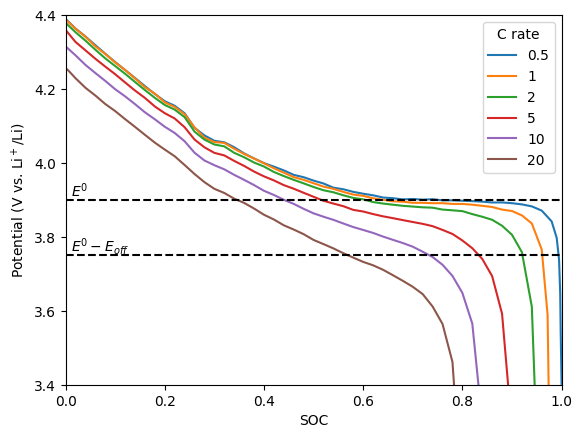

In [3]:
fig, ax = plt.subplots()

sys = "LCO"

dataframes = [
    pd.read_csv(path + sys + f"/{cr}C.csv", header=None) for cr in C_rates[sys]
]

for cr, df in zip(C_rates[sys], dataframes):
    ax.plot(df[0] / xmax[sys], df[1], label=f"{cr}")

dtext = 0.01

ax.axhline(y=eq_pot[sys], color="k", linestyle="--")
ax.text(0 + dtext, eq_pot[sys] + dtext, r"$E^0$")

ax.axhline(y=eq_pot[sys] - 0.15, color="k", linestyle="--")
ax.text(0 + dtext, eq_pot[sys] - 0.15 + dtext, r"$E^0 - E_{off}$")

ax.set_xlim((0, 1))
ax.set_ylim((eq_pot[sys] - 0.5, eq_pot[sys] + 0.5))
ax.set_xlabel(r"SOC")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
    
ax.legend(title="C rate")
plt.show()

This are measurements corresponds with galvanostatic potentials profiles at different C-rates. The horizontal lines are the equilibrium potential and a cut-off voltage 0.15 V below this value, which is the value used in the simulations of the map. We need to calculate from them the maximum SOC values at which the curve intersects this last line. This can be done with the `preprocessing` module of **galpynostatic**:

In [4]:
import galpynostatic
galpynostatic.VERSION

'0.0.1'

We transform the data in this way by normalizing the discharge capacities to obtain the SOC.

In [5]:
gregs, X_train, y_train = {}, {}, {}
for sys in systems:
    if eq_pot[sys] is None:
        df = pd.read_csv(path + sys + "/df.csv")
        
        X = df["C_rates"].to_numpy()
        y = df["SOC_exp"].to_numpy()
        
    else:
        dataframes = [pd.read_csv(path + sys + f"/{cr}C.csv") for cr in C_rates[sys]]
        
        gdc = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot=eq_pot[sys])
        dc = gdc.fit_transform(dataframes)
        
        X = np.array(C_rates[sys])
        y = dc / xmax[sys]
        
    X_train[sys] = X.reshape(-1, 1)
    y_train[sys] = y

## Model fitting

We load the spherical dataset to use it for all the experimental data

In [6]:
spherical = galpynostatic.datasets.load_spherical()

We fit each model and display the diffusion coefficient and the kinetic rate constant

In [7]:
print(r"system: D [cm^2/s], k0 [cm/s]")
gregs = {}
for sys in systems:
    greg = galpynostatic.model.GalvanostaticRegressor(dataset=spherical, d=lenght[sys], z=3)
    greg.fit(X_train[sys], y_train[sys])
    
    print(f"{sys}: {greg.dcoeff_:.3e} +/- {greg.dcoeff_err_:.0e}, {greg.k0_:.3e} +/- {greg.k0_err_:.0e}")
    
    gregs[sys] = greg

system: D [cm^2/s], k0 [cm/s]
NATURAL_GRAPHITE: 1.233e-10 +/- 1e-13, 2.310e-07 +/- 1e-09
LTO: 6.579e-12 +/- 6e-14, 8.111e-08 +/- 7e-09
LFP: 2.848e-13 +/- 1e-14, 1.000e-09 +/- 3e-11
LCO: 5.337e-09 +/- 2e-10, 1.000e-05 +/- 1e-05
LMO: 3.511e-14 +/- 3e-16, 1.874e-08 +/- 1e-09
LMNO: 1.233e-09 +/- 3e-10, 1.233e-06 +/- 1e-06


These obtained values are discussed and compared with the experimental ones in the article.

## Model visualization

Visualize model SOC predictions versus training data.

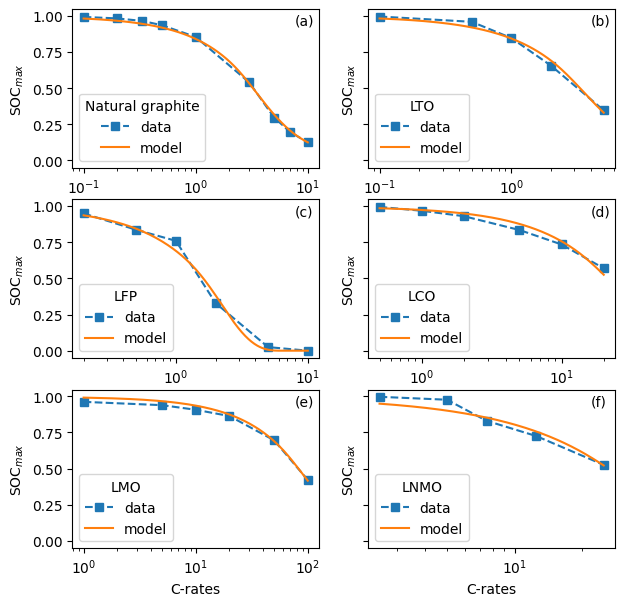

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(7, 7))
ax = ax.ravel()

for i, (sys, let) in enumerate(zip(systems, letters)):
    gregs[sys].plot.versus_data(X_train[sys], y_train[sys], ax=ax[i])
    
    ax[i].set_ylabel(r"SOC$_{max}$")
    ax[i].text(0.9, 0.9, let, transform=ax[i].transAxes)
    ax[i].legend(title=label[sys], loc="lower left")
plt.show()

We can see an overall good agreement between the model and the experimental counterpart. We can plot the predicted maximum SOC values as a function of experimental results and see the linear trend. The coefficient of determination is also calculated.

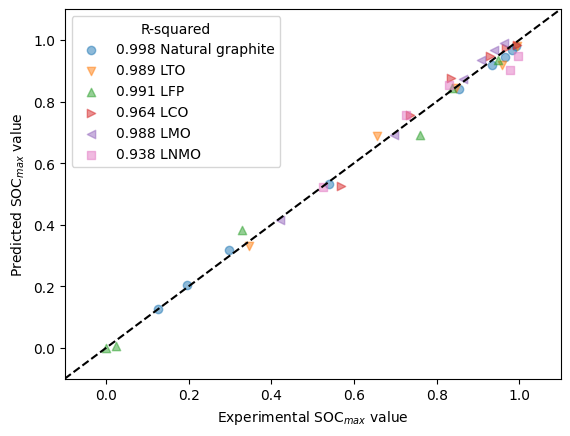

In [9]:
fig, ax = plt.subplots()

ax.plot([-0.1, 1.1], [-0.1, 1.1], ls="dashed", c="k")

for sys in systems:
    y_pred = gregs[sys].predict(X_train[sys])
    ax.scatter(
        y_train[sys], 
        y_pred, 
        marker=marker[sys], 
        color=color[sys], 
        alpha=0.5, 
        label=f"{gregs[sys].score(X_train[sys], y_train[sys]):.3f} {label[sys]}"
    )
    
ax.set_xlim((-0.1, 1.1))
ax.set_ylim((-0.1, 1.1))

ax.set_xlabel(r"Experimental SOC$_{max}$ value")
ax.set_ylabel(r"Predicted SOC$_{max}$ value")

ax.legend(title="R-squared")

plt.show()


These fitted models can also be displayed in the simulated map to see the location of each one. 

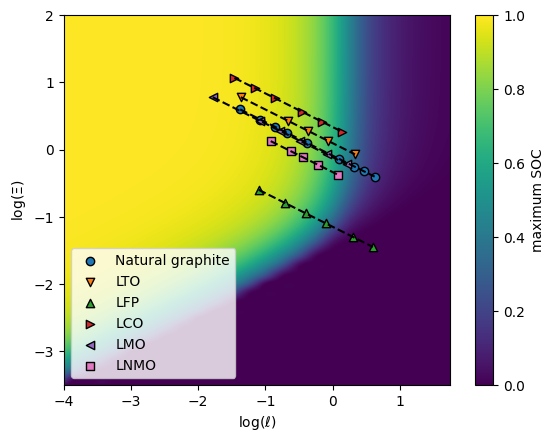

In [10]:
fig, ax = plt.subplots()

greg = galpynostatic.model.GalvanostaticRegressor(dataset=spherical)
greg._map = galpynostatic.datasets.map.MapSpline(spherical) # artificial fit 
greg.plot.render_map(ax=ax)

for sys in systems:
    # gregs[sys].plot.in_render_map(
    #     X_train[sys], ax=ax, marker=marker[sys], color=color[sys], label=label[sys]
    # )
    logells = galpynostatic.utils.logell(
        X_train[sys], lenght[sys], 3, gregs[sys].dcoeff_
    )
    logxis = galpynostatic.utils.logxi(
        X_train[sys], gregs[sys].dcoeff_, gregs[sys].k0_
    )
    
    ax.plot(logells, logxis, color="k", linestyle="--")
    ax.scatter(
        logells, 
        logxis, 
        marker=marker[sys], 
        color=color[sys],
        edgecolor="k", 
        label=label[sys],
    )
    
ax.legend()
    
plt.show()

## Comparison of systems at different sizes

We compare the merits of different materials in terms of their intrinsic properties ($D$, $k^0$) by considering different particle sizes and C-rates.

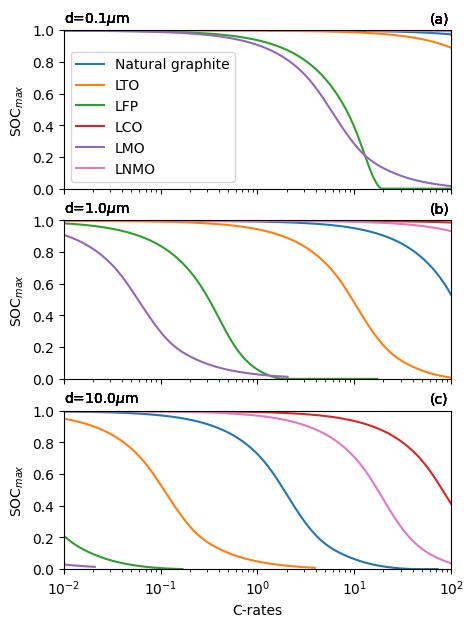

In [11]:
dvalues = [1e-5, 1e-4, 1e-3]

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5, 7))
ax.ravel()

crates = np.logspace(-2, 2, num=200).reshape(-1, 1)

for i, (d, let) in enumerate(zip(dvalues, letters[:3])):
    for sys in systems:
        gregs[sys].d = d
        
        socs = gregs[sys].predict(crates)
        
        ax[i].plot(crates, socs, color=color[sys], label=label[sys])        
        
        ax[i].text(1e-2, 1.05, rf"d={10000 * d}$\mu$m")
        ax[i].text(60, 1.05, let)

        ax[i].set_xscale("log")
        ax[i].set_xlim((1e-2, 1e2))

        ax[i].set_ylim(0, 1)
        ax[i].set_ylabel(r"SOC$_{max}$")

ax[0].legend()
ax[2].set_xlabel("C-rates")

plt.show()

The same can be seen in the map

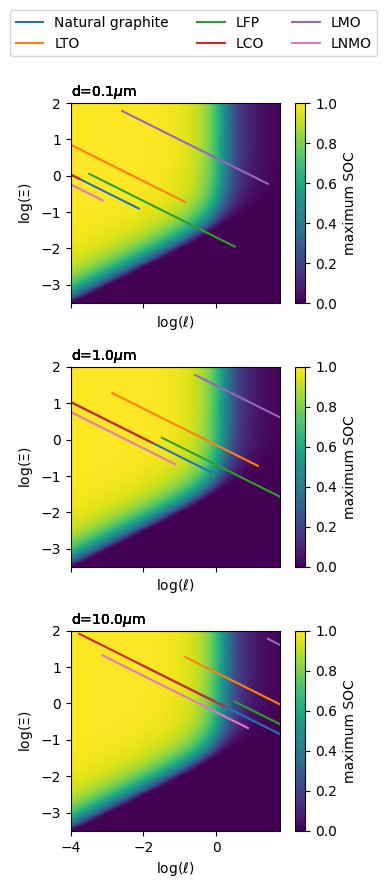

In [12]:
import matplotlib.cm as cm 

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4, 9))
ax = ax.ravel()

cmap = cm.get_cmap("viridis")
sm = plt.cm.ScalarMappable(cmap=cmap)

crates = np.logspace(-2, 2, num=200).reshape(-1, 1)

for i, d in enumerate(dvalues):
    greg.plot.render_map(ax=ax[i], clb=False)
    
    for sys in systems:
        gregs[sys].d = d
        
        gregs[sys].plot.in_render_map(
            crates,
            ax=ax[i], 
            marker="", 
            linestyle="solid", 
            color=color[sys], 
            label=label[sys],
        )
        
        ax[i].text(-4, 2.2, rf"d={d*10_000}$\mu$m")  
    
    ax[i].set_xlim((-4, 1.75))
    ax[i].set_ylim((-3.5, 2))
    
    clb = fig.colorbar(sm, ax=ax[i], location="right")
    clb.ax.set_ylabel("maximum SOC")
    
ax[0].legend(loc="upper right", bbox_to_anchor=(1.5, 1.5), ncol=3)

plt.tight_layout()
plt.show()

Discussions regarding this herarchization are made in the article. We return the models to their original particle sizes.

In [13]:
for sys in systems:
    gregs[sys].d = lenght[sys]

## Prediction of the characteristic length to charge the electrode material in fifteen minutes

We follow the standard of the USABC (_United States Advanced Battery Consortium_), which aims for extremely fast-charging of 15 minutes for 80% of the SOC (red line).

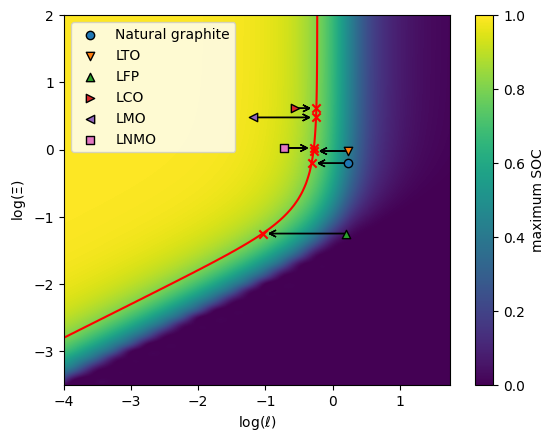

In [14]:
fig, ax = plt.subplots()

greg.plot.render_map(ax=ax)
X = np.linspace(-4, 1.75, num=100)
Y = np.linspace(-3.5, 2, num=100)
Z = greg._map.soc(X, Y, grid=True).T
ax.contour(X, Y, Z, levels=np.array([0.8]), colors="red")

delta = 0.1
for sys in systems:
    optimal_d, _ = galpynostatic.make_prediction.optimal_particle_size(gregs[sys], cm_to=1)
    
    logxi = galpynostatic.utils.logxi(4, gregs[sys].dcoeff_, gregs[sys].k0_)
    logell = galpynostatic.utils.logell(4, gregs[sys].d, 3, gregs[sys].dcoeff_)  
    new_logell = galpynostatic.utils.logell(4, optimal_d, 3, gregs[sys].dcoeff_)
    dl = new_logell - logell
    
    ax.scatter(new_logell, logxi, color="red", marker="x")
    
    ax.arrow(
        logell, 
        logxi,
        dl - 2.0 * delta if dl > 0 else dl + 2.0 * delta, 
        0,
        fc="k",
        head_width=delta, 
        head_length=delta, 
        overhang=1,
    )
    ax.scatter(
        logell,
        logxi,
        marker=marker[sys],
        color=color[sys], 
        edgecolors="k",
        label=label[sys]
    )

ax.legend(loc="upper left")
plt.show()

We can predict the particle size needed to satisfy the USABC criteria (displacement of points in the map to reach the contour line) and also for 5 minutes charging.

In [15]:
print("system: original d, d 15 minutes, d 5 minutes # all in micrometers")
for sys in systems:
    d15, d15_err = galpynostatic.make_prediction.optimal_particle_size(gregs[sys], minutes=15)
    d5, d5_err = galpynostatic.make_prediction.optimal_particle_size(gregs[sys], minutes=5)
    
    print(f"{sys}: {1e4 * gregs[sys].d:.3f}, {d15:.4f} +/- {d15_err:.4f}, {d5:.4f} +/- {d5_err:.4f}")

system: original d, d 15 minutes, d 5 minutes # all in micrometers
NATURAL_GRAPHITE: 7.500, 4.0270 +/- 0.0020, 2.1670 +/- 0.0011
LTO: 1.750, 0.9616 +/- 0.0041, 0.5299 +/- 0.0023
LFP: 0.350, 0.0836 +/- 0.0015, 0.0309 +/- 0.0006
LCO: 20.000, 28.7715 +/- 0.6393, 16.4318 +/- 0.3651
LMO: 0.025, 0.0734 +/- 0.0003, 0.0418 +/- 0.0002
LMNO: 7.999, 13.2472 +/- 1.5226, 7.3337 +/- 0.8429


The behaviour of the optimal particle size depends on the system and the particular experiment considered.